![Step-by-step Transfer Learning](./res/title.jpg "Step-by-step Transfer Learning")

![Data](./res/data.jpg "Data")

In [1]:
import keras
import numpy as np
import os
import matplotlib.pyplot as plt

C:\ProgramData\Anaconda3\envs\test-meetup\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Define some constants.
labels = ['Left', 'Right', 'Front', 'Rear']
num_classes = len(labels)

In [3]:
from keras.preprocessing.image import load_img, img_to_array
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from tqdm import tqdm # Used to display a progress bar when loading images.

class ImageDataset:
    def __init__(self):
        self.images = []
        self.labels = []

    def add(self, dir, label):
        """ Adds the paths to all .jpg files in the given directory
        to the dataset and labels them. Note: This does not load any
        files. """
        # Get a list of all .jpg files in dir.
        files = [os.path.join(dir, f) for f in os.listdir(dir) if f.endswith('.jpg')]
        # Append files and labels.
        self.images += files
        self.labels += [label] * len(files)
        
    def size(self):
        return len(self.images)

    def generate(self, test_split=0.33):
        """ Loads the image files for the stored paths and returns a
        training/test split of inputs and labels in a format suitable
        for Keras. (
            x = [count, x, y, channel]
            y = [[1, 0, 0, 0], [0, 1, 0, 0], .. ]
        """
        # Load images.
        x = np.vstack([self._load_img(img) for img in tqdm(self.images)])
        # One-hot encode labels.
        y = to_categorical(self.labels)
        # Returns train/test split.
        return train_test_split(x, y, test_size=test_split, random_state=42)

    def _load_img(self, path):
        """ Loads an image from path and converts it to a 4-dimensional
        tensor to be passed to a Keras model 
            x = [1, x, y, channel]
        """
        img = img_to_array(load_img(path, target_size=(224, 224)))
        return np.expand_dims(img, axis=0)

In [4]:
# Create an instance of the dataset and add the image folder for each label to it.
dataset = ImageDataset()
for idx, label in enumerate(labels):
    # Create a path from the label and add the directory to the dataset.
    path = os.path.join('images', label)
    dataset.add(path, idx)
print("Added {} images to dataset.".format(dataset.size()))
# Create the training/test split.
x_train, x_test, y_train, y_test = dataset.generate(0.25)

Added 1239 images to dataset.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1239/1239 [00:47<00:00, 25.97it/s]


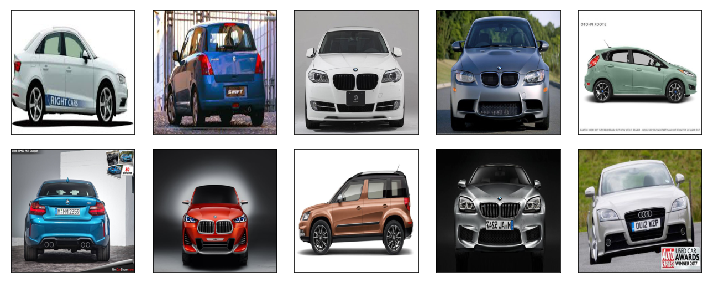

In [5]:
# Display 10 random samples from the training dataset.
indices = np.random.choice(len(x_train), 10)
fig = plt.figure(figsize=(10, 4))
for i, idx in enumerate(indices):
    # Add a subplot for each image.
    ax = fig.add_subplot(2, 5, i+1)
    # Hide the axes.
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    # Add image to current subplot.
    plt.imshow(x_train[idx] / 255)
# Show plot.
plt.tight_layout()
plt.show()

![Processing](./res/processing.jpg "Processing")

In [6]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input

# We use the ResNet50 as a feature extractor. 
# Load the ResNet50 trained on the Imagenet dataset.
resnet = ResNet50(weights='imagenet', include_top=False)
# Run training and test inputs through the network.
# Note: depending on the size of your dataset this might take a couple of minutes.
x_train = resnet.predict(preprocess_input(np.copy(x_train)))
x_test = resnet.predict(preprocess_input(np.copy(x_test)))

![Model](./res/model.jpg "Model")

In [7]:
# Define constants.
input_shape = x_train.shape[1:]

In [8]:
# Create the model.
model = keras.models.Sequential()
# We require a Flatten layer, because the output of the ResNet has a higher dimension, which
# we cannot feed into our classification layer as is.
model.add(keras.layers.Flatten(input_shape=input_shape))
model.add(keras.layers.Dense(num_classes, activation='softmax'))
# Compile the model.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


![Training](./res/training.jpg "Training")

In [9]:
# Define constants.
epochs = 500
batch_size = 75
validation_split = 0.33

In [10]:
# Train the model.
checkpoint = keras.callbacks.ModelCheckpoint(filepath='best.weights.01.hdf5', save_best_only=True)
progress = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, callbacks=[checkpoint])

Train on 622 samples, validate on 307 samples
Epoch 1/500
622/622 [==============================] - ETA: 3s - loss: 1.8953 - acc: 0.226 - 1s 1ms/step - loss: 1.2889 - acc: 0.4228 - val_loss: 0.9934 - val_acc: 0.5407
Epoch 2/500
622/622 [==============================] - ETA: 0s - loss: 0.8972 - acc: 0.600 - 0s 63us/step - loss: 0.7283 - acc: 0.6994 - val_loss: 0.6659 - val_acc: 0.6971
Epoch 3/500
622/622 [==============================] - ETA: 0s - loss: 0.6509 - acc: 0.680 - 0s 65us/step - loss: 0.5059 - acc: 0.8039 - val_loss: 0.5410 - val_acc: 0.7622
Epoch 4/500
622/622 [==============================] - ETA: 0s - loss: 0.4936 - acc: 0.813 - 0s 62us/step - loss: 0.4097 - acc: 0.8328 - val_loss: 0.4969 - val_acc: 0.7590
Epoch 5/500
622/622 [==============================] - ETA: 0s - loss: 0.4230 - acc: 0.840 - 0s 64us/step - loss: 0.3610 - acc: 0.8521 - val_loss: 0.4623 - val_acc: 0.7818
Epoch 6/500
622/622 [==============================] - ETA: 0s - loss: 0.3356 - acc: 0.893 - 0s

622/622 [==============================] - ETA: 0s - loss: 0.1040 - acc: 0.986 - 0s 27us/step - loss: 0.0836 - acc: 0.9952 - val_loss: 0.3428 - val_acc: 0.8436
Epoch 49/500
622/622 [==============================] - ETA: 0s - loss: 0.0551 - acc: 0.986 - 0s 29us/step - loss: 0.0821 - acc: 0.9968 - val_loss: 0.3417 - val_acc: 0.8534
Epoch 50/500
622/622 [==============================] - ETA: 0s - loss: 0.0633 - acc: 1.000 - 0s 29us/step - loss: 0.0844 - acc: 0.9871 - val_loss: 0.3513 - val_acc: 0.8436
Epoch 51/500
622/622 [==============================] - ETA: 0s - loss: 0.0575 - acc: 1.000 - 0s 31us/step - loss: 0.0806 - acc: 0.9968 - val_loss: 0.3459 - val_acc: 0.8567
Epoch 52/500
622/622 [==============================] - ETA: 0s - loss: 0.0802 - acc: 0.986 - 0s 29us/step - loss: 0.0821 - acc: 0.9839 - val_loss: 0.3592 - val_acc: 0.8306
Epoch 53/500
622/622 [==============================] - ETA: 0s - loss: 0.1102 - acc: 0.986 - 0s 35us/step - loss: 0.0798 - acc: 0.9968 - val_loss: 

622/622 [==============================] - ETA: 0s - loss: 0.0338 - acc: 1.000 - 0s 27us/step - loss: 0.0434 - acc: 1.0000 - val_loss: 0.3580 - val_acc: 0.8567
Epoch 96/500
622/622 [==============================] - ETA: 0s - loss: 0.0406 - acc: 1.000 - 0s 28us/step - loss: 0.0409 - acc: 1.0000 - val_loss: 0.3581 - val_acc: 0.8567
Epoch 97/500
622/622 [==============================] - ETA: 0s - loss: 0.0512 - acc: 1.000 - 0s 28us/step - loss: 0.0397 - acc: 1.0000 - val_loss: 0.3575 - val_acc: 0.8534
Epoch 98/500
622/622 [==============================] - ETA: 0s - loss: 0.0262 - acc: 1.000 - 0s 27us/step - loss: 0.0395 - acc: 1.0000 - val_loss: 0.3627 - val_acc: 0.8534
Epoch 99/500
622/622 [==============================] - ETA: 0s - loss: 0.0333 - acc: 1.000 - 0s 28us/step - loss: 0.0393 - acc: 1.0000 - val_loss: 0.3622 - val_acc: 0.8502
Epoch 100/500
622/622 [==============================] - ETA: 0s - loss: 0.0338 - acc: 1.000 - 0s 27us/step - loss: 0.0389 - acc: 1.0000 - val_loss:

622/622 [==============================] - ETA: 0s - loss: 0.0196 - acc: 1.000 - 0s 29us/step - loss: 0.0241 - acc: 1.0000 - val_loss: 0.3785 - val_acc: 0.8469
Epoch 143/500
622/622 [==============================] - ETA: 0s - loss: 0.0321 - acc: 1.000 - 0s 28us/step - loss: 0.0239 - acc: 1.0000 - val_loss: 0.3795 - val_acc: 0.8436
Epoch 144/500
622/622 [==============================] - ETA: 0s - loss: 0.0187 - acc: 1.000 - 0s 27us/step - loss: 0.0236 - acc: 1.0000 - val_loss: 0.3776 - val_acc: 0.8534
Epoch 145/500
622/622 [==============================] - ETA: 0s - loss: 0.0287 - acc: 1.000 - 0s 28us/step - loss: 0.0234 - acc: 1.0000 - val_loss: 0.3800 - val_acc: 0.8469
Epoch 146/500
622/622 [==============================] - ETA: 0s - loss: 0.0339 - acc: 1.000 - 0s 28us/step - loss: 0.0231 - acc: 1.0000 - val_loss: 0.3799 - val_acc: 0.8502
Epoch 147/500
622/622 [==============================] - ETA: 0s - loss: 0.0182 - acc: 1.000 - 0s 29us/step - loss: 0.0229 - acc: 1.0000 - val_l

622/622 [==============================] - ETA: 0s - loss: 0.0126 - acc: 1.000 - 0s 28us/step - loss: 0.0155 - acc: 1.0000 - val_loss: 0.3967 - val_acc: 0.8502
Epoch 190/500
622/622 [==============================] - ETA: 0s - loss: 0.0196 - acc: 1.000 - 0s 28us/step - loss: 0.0154 - acc: 1.0000 - val_loss: 0.3947 - val_acc: 0.8469
Epoch 191/500
622/622 [==============================] - ETA: 0s - loss: 0.0147 - acc: 1.000 - 0s 28us/step - loss: 0.0162 - acc: 1.0000 - val_loss: 0.3975 - val_acc: 0.8534
Epoch 192/500
622/622 [==============================] - ETA: 0s - loss: 0.0147 - acc: 1.000 - 0s 27us/step - loss: 0.0154 - acc: 1.0000 - val_loss: 0.3982 - val_acc: 0.8534
Epoch 193/500
622/622 [==============================] - ETA: 0s - loss: 0.0195 - acc: 1.000 - 0s 29us/step - loss: 0.0150 - acc: 1.0000 - val_loss: 0.3968 - val_acc: 0.8469
Epoch 194/500
622/622 [==============================] - ETA: 0s - loss: 0.0098 - acc: 1.000 - 0s 29us/step - loss: 0.0149 - acc: 1.0000 - val_l

622/622 [==============================] - ETA: 0s - loss: 0.0127 - acc: 1.000 - 0s 28us/step - loss: 0.0107 - acc: 1.0000 - val_loss: 0.4146 - val_acc: 0.8469
Epoch 237/500
622/622 [==============================] - ETA: 0s - loss: 0.0054 - acc: 1.000 - 0s 31us/step - loss: 0.0110 - acc: 1.0000 - val_loss: 0.4139 - val_acc: 0.8469
Epoch 238/500
622/622 [==============================] - ETA: 0s - loss: 0.0112 - acc: 1.000 - 0s 27us/step - loss: 0.0112 - acc: 1.0000 - val_loss: 0.4153 - val_acc: 0.8469
Epoch 239/500
622/622 [==============================] - ETA: 0s - loss: 0.0073 - acc: 1.000 - 0s 35us/step - loss: 0.0105 - acc: 1.0000 - val_loss: 0.4137 - val_acc: 0.8469
Epoch 240/500
622/622 [==============================] - ETA: 0s - loss: 0.0074 - acc: 1.000 - 0s 28us/step - loss: 0.0106 - acc: 1.0000 - val_loss: 0.4155 - val_acc: 0.8436
Epoch 241/500
622/622 [==============================] - ETA: 0s - loss: 0.0126 - acc: 1.000 - 0s 29us/step - loss: 0.0104 - acc: 1.0000 - val_l

622/622 [==============================] - ETA: 0s - loss: 0.0090 - acc: 1.000 - 0s 31us/step - loss: 0.0077 - acc: 1.0000 - val_loss: 0.4315 - val_acc: 0.8469
Epoch 284/500
622/622 [==============================] - ETA: 0s - loss: 0.0082 - acc: 1.000 - 0s 30us/step - loss: 0.0076 - acc: 1.0000 - val_loss: 0.4317 - val_acc: 0.8436
Epoch 285/500
622/622 [==============================] - ETA: 0s - loss: 0.0093 - acc: 1.000 - 0s 31us/step - loss: 0.0077 - acc: 1.0000 - val_loss: 0.4324 - val_acc: 0.8469
Epoch 286/500
622/622 [==============================] - ETA: 0s - loss: 0.0084 - acc: 1.000 - 0s 30us/step - loss: 0.0075 - acc: 1.0000 - val_loss: 0.4335 - val_acc: 0.8469
Epoch 287/500
622/622 [==============================] - ETA: 0s - loss: 0.0071 - acc: 1.000 - 0s 31us/step - loss: 0.0076 - acc: 1.0000 - val_loss: 0.4326 - val_acc: 0.8469
Epoch 288/500
622/622 [==============================] - ETA: 0s - loss: 0.0067 - acc: 1.000 - 0s 28us/step - loss: 0.0074 - acc: 1.0000 - val_l

622/622 [==============================] - ETA: 0s - loss: 0.0057 - acc: 1.000 - 0s 30us/step - loss: 0.0057 - acc: 1.0000 - val_loss: 0.4456 - val_acc: 0.8469
Epoch 331/500
622/622 [==============================] - ETA: 0s - loss: 0.0049 - acc: 1.000 - 0s 31us/step - loss: 0.0057 - acc: 1.0000 - val_loss: 0.4457 - val_acc: 0.8469
Epoch 332/500
622/622 [==============================] - ETA: 0s - loss: 0.0030 - acc: 1.000 - 0s 31us/step - loss: 0.0056 - acc: 1.0000 - val_loss: 0.4465 - val_acc: 0.8469
Epoch 333/500
622/622 [==============================] - ETA: 0s - loss: 0.0049 - acc: 1.000 - 0s 31us/step - loss: 0.0056 - acc: 1.0000 - val_loss: 0.4471 - val_acc: 0.8436
Epoch 334/500
622/622 [==============================] - ETA: 0s - loss: 0.0073 - acc: 1.000 - 0s 30us/step - loss: 0.0055 - acc: 1.0000 - val_loss: 0.4474 - val_acc: 0.8469
Epoch 335/500
622/622 [==============================] - ETA: 0s - loss: 0.0051 - acc: 1.000 - 0s 29us/step - loss: 0.0055 - acc: 1.0000 - val_l

622/622 [==============================] - ETA: 0s - loss: 0.0043 - acc: 1.000 - 0s 29us/step - loss: 0.0043 - acc: 1.0000 - val_loss: 0.4612 - val_acc: 0.8469
Epoch 378/500
622/622 [==============================] - ETA: 0s - loss: 0.0039 - acc: 1.000 - 0s 28us/step - loss: 0.0042 - acc: 1.0000 - val_loss: 0.4614 - val_acc: 0.8469
Epoch 379/500
622/622 [==============================] - ETA: 0s - loss: 0.0057 - acc: 1.000 - 0s 28us/step - loss: 0.0042 - acc: 1.0000 - val_loss: 0.4614 - val_acc: 0.8436
Epoch 380/500
622/622 [==============================] - ETA: 0s - loss: 0.0026 - acc: 1.000 - 0s 29us/step - loss: 0.0042 - acc: 1.0000 - val_loss: 0.4626 - val_acc: 0.8469
Epoch 381/500
622/622 [==============================] - ETA: 0s - loss: 0.0032 - acc: 1.000 - 0s 27us/step - loss: 0.0041 - acc: 1.0000 - val_loss: 0.4638 - val_acc: 0.8469
Epoch 382/500
622/622 [==============================] - ETA: 0s - loss: 0.0049 - acc: 1.000 - 0s 29us/step - loss: 0.0042 - acc: 1.0000 - val_l

622/622 [==============================] - ETA: 0s - loss: 0.0024 - acc: 1.000 - 0s 32us/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.4761 - val_acc: 0.8469
Epoch 425/500
622/622 [==============================] - ETA: 0s - loss: 0.0037 - acc: 1.000 - 0s 31us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.4758 - val_acc: 0.8469
Epoch 426/500
622/622 [==============================] - ETA: 0s - loss: 0.0022 - acc: 1.000 - 0s 29us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.4754 - val_acc: 0.8502
Epoch 427/500
622/622 [==============================] - ETA: 0s - loss: 0.0043 - acc: 1.000 - 0s 28us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.4758 - val_acc: 0.8469
Epoch 428/500
622/622 [==============================] - ETA: 0s - loss: 0.0016 - acc: 1.000 - 0s 30us/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.4762 - val_acc: 0.8469
Epoch 429/500
622/622 [==============================] - ETA: 0s - loss: 0.0043 - acc: 1.000 - 0s 31us/step - loss: 0.0032 - acc: 1.0000 - val_l

622/622 [==============================] - ETA: 0s - loss: 0.0014 - acc: 1.000 - 0s 31us/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.4912 - val_acc: 0.8436
Epoch 472/500
622/622 [==============================] - ETA: 0s - loss: 0.0020 - acc: 1.000 - 0s 28us/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.4910 - val_acc: 0.8436
Epoch 473/500
622/622 [==============================] - ETA: 0s - loss: 0.0022 - acc: 1.000 - 0s 31us/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.4908 - val_acc: 0.8436
Epoch 474/500
622/622 [==============================] - ETA: 0s - loss: 0.0020 - acc: 1.000 - 0s 30us/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.4919 - val_acc: 0.8436
Epoch 475/500
622/622 [==============================] - ETA: 0s - loss: 0.0023 - acc: 1.000 - 0s 34us/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.4916 - val_acc: 0.8436
Epoch 476/500
622/622 [==============================] - ETA: 0s - loss: 0.0020 - acc: 1.000 - 0s 35us/step - loss: 0.0025 - acc: 1.0000 - val_l

![Evaluation](./res/evaluation.jpg "Evaluation")

In [11]:
from sklearn.metrics import confusion_matrix

# Define helper functions to plot training progress and confusion matrix.

def plot_loss(progress):
    plt.plot(progress.history['loss'])
    plt.plot(progress.history['val_loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    leg = plt.legend(['Training Loss', 'Validation Loss'])
    plt.show()
    
    
def plot_confusion(model):
    # Get validation data from the end of the training set.
    validation_size = round(validation_split * len(x_train))
    # Make predictions.
    predictions = model.predict_classes(x_train[-validation_size:])
    # Invert one-hot encoding to get expectations.
    expectations = np.argmax(y_train[-validation_size:], axis=1)
    # Plot confusion matrix.
    matrix = confusion_matrix(expectations, predictions)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    # Set matrix labels.
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    # Show matrix and return the matrix values.
    ax.matshow(matrix)
    return matrix

In [12]:
# Restore the best weights and print the best validation score.
model.load_weights('best.weights.01.hdf5')
np.max(progress.history['val_acc'])

0.8566775387972108

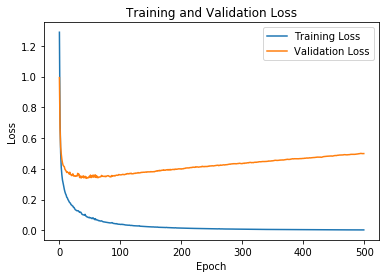

In [13]:
plot_loss(progress)

307/307 [==============================] - ETA:  - 0s 365us/step


array([[ 25,  22,   0,   0],
       [ 15,  36,   0,   1],
       [  0,   1, 122,   2],
       [  1,   0,   4,  78]], dtype=int64)

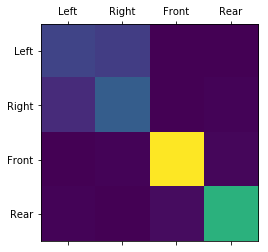

In [14]:
plot_confusion(model)

![Model](./res/model.jpg "Model")

In [15]:
# Iterate and define a new model.
model2 = keras.models.Sequential()
model2.add(keras.layers.Flatten(input_shape=input_shape))
# Add a dropout layer for regularization.
model2.add(keras.layers.Dropout(0.75))
model2.add(keras.layers.Dense(num_classes, activation='softmax'))
# Compile the model.
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

![Training](./res/training.jpg "Training")

In [16]:
# Train the model.
checkpoint = keras.callbacks.ModelCheckpoint(filepath='best.weights.02.hdf5', save_best_only=True)
progress2 = model2.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, callbacks=[checkpoint])

Train on 622 samples, validate on 307 samples
Epoch 1/500
622/622 [==============================] - ETA: 3s - loss: 2.4533 - acc: 0.240 - 1s 1ms/step - loss: 1.8571 - acc: 0.4132 - val_loss: 1.0484 - val_acc: 0.5505
Epoch 2/500
622/622 [==============================] - ETA: 0s - loss: 1.6398 - acc: 0.493 - 0s 94us/step - loss: 1.2531 - acc: 0.5514 - val_loss: 0.7288 - val_acc: 0.6319
Epoch 3/500
622/622 [==============================] - ETA: 0s - loss: 1.1178 - acc: 0.586 - 0s 79us/step - loss: 0.9599 - acc: 0.6174 - val_loss: 0.6235 - val_acc: 0.6743
Epoch 4/500
622/622 [==============================] - ETA: 0s - loss: 0.9140 - acc: 0.653 - 0s 73us/step - loss: 0.8721 - acc: 0.6495 - val_loss: 0.5358 - val_acc: 0.7590
Epoch 5/500
622/622 [==============================] - ETA: 0s - loss: 0.9146 - acc: 0.640 - 0s 75us/step - loss: 0.7309 - acc: 0.6897 - val_loss: 0.5199 - val_acc: 0.7362
Epoch 6/500
622/622 [==============================] - ETA: 0s - loss: 0.6359 - acc: 0.746 - 0s

622/622 [==============================] - ETA: 0s - loss: 0.2708 - acc: 0.906 - 0s 43us/step - loss: 0.2757 - acc: 0.8746 - val_loss: 0.3710 - val_acc: 0.8208
Epoch 49/500
622/622 [==============================] - ETA: 0s - loss: 0.3064 - acc: 0.866 - 0s 43us/step - loss: 0.2451 - acc: 0.8939 - val_loss: 0.3771 - val_acc: 0.8176
Epoch 50/500
622/622 [==============================] - ETA: 0s - loss: 0.3496 - acc: 0.840 - 0s 42us/step - loss: 0.2520 - acc: 0.8955 - val_loss: 0.3764 - val_acc: 0.8208
Epoch 51/500
622/622 [==============================] - ETA: 0s - loss: 0.1922 - acc: 0.933 - 0s 42us/step - loss: 0.2400 - acc: 0.9003 - val_loss: 0.3637 - val_acc: 0.8274
Epoch 52/500
622/622 [==============================] - ETA: 0s - loss: 0.2237 - acc: 0.906 - 0s 43us/step - loss: 0.2679 - acc: 0.8762 - val_loss: 0.3885 - val_acc: 0.8078
Epoch 53/500
622/622 [==============================] - ETA: 0s - loss: 0.2712 - acc: 0.866 - 0s 43us/step - loss: 0.2641 - acc: 0.8810 - val_loss: 

622/622 [==============================] - ETA: 0s - loss: 0.1778 - acc: 0.906 - 0s 42us/step - loss: 0.2101 - acc: 0.9019 - val_loss: 0.3823 - val_acc: 0.8176
Epoch 96/500
622/622 [==============================] - ETA: 0s - loss: 0.1628 - acc: 0.946 - 0s 41us/step - loss: 0.2219 - acc: 0.8971 - val_loss: 0.3732 - val_acc: 0.8078
Epoch 97/500
622/622 [==============================] - ETA: 0s - loss: 0.2912 - acc: 0.826 - 0s 42us/step - loss: 0.2421 - acc: 0.8746 - val_loss: 0.3698 - val_acc: 0.8143
Epoch 98/500
622/622 [==============================] - ETA: 0s - loss: 0.1414 - acc: 0.946 - 0s 41us/step - loss: 0.2157 - acc: 0.9019 - val_loss: 0.3691 - val_acc: 0.8306
Epoch 99/500
622/622 [==============================] - ETA: 0s - loss: 0.2693 - acc: 0.880 - 0s 40us/step - loss: 0.2158 - acc: 0.9035 - val_loss: 0.3686 - val_acc: 0.8208
Epoch 100/500
622/622 [==============================] - ETA: 0s - loss: 0.1458 - acc: 0.933 - 0s 41us/step - loss: 0.2220 - acc: 0.9051 - val_loss:

622/622 [==============================] - ETA: 0s - loss: 0.2125 - acc: 0.933 - 0s 44us/step - loss: 0.2047 - acc: 0.9132 - val_loss: 0.3620 - val_acc: 0.8241
Epoch 143/500
622/622 [==============================] - ETA: 0s - loss: 0.3329 - acc: 0.853 - 0s 43us/step - loss: 0.2132 - acc: 0.9068 - val_loss: 0.3472 - val_acc: 0.8339
Epoch 144/500
622/622 [==============================] - ETA: 0s - loss: 0.2227 - acc: 0.893 - 0s 43us/step - loss: 0.1914 - acc: 0.9035 - val_loss: 0.3531 - val_acc: 0.8436
Epoch 145/500
622/622 [==============================] - ETA: 0s - loss: 0.1901 - acc: 0.920 - 0s 65us/step - loss: 0.1839 - acc: 0.9293 - val_loss: 0.3444 - val_acc: 0.8404
Epoch 146/500
622/622 [==============================] - ETA: 0s - loss: 0.2266 - acc: 0.866 - 0s 43us/step - loss: 0.2290 - acc: 0.8907 - val_loss: 0.3615 - val_acc: 0.8078
Epoch 147/500
622/622 [==============================] - ETA: 0s - loss: 0.1381 - acc: 0.920 - 0s 64us/step - loss: 0.2169 - acc: 0.8939 - val_l

622/622 [==============================] - ETA: 0s - loss: 0.2500 - acc: 0.920 - 0s 43us/step - loss: 0.1800 - acc: 0.9277 - val_loss: 0.3605 - val_acc: 0.8208
Epoch 190/500
622/622 [==============================] - ETA: 0s - loss: 0.2115 - acc: 0.906 - 0s 41us/step - loss: 0.1873 - acc: 0.9148 - val_loss: 0.3528 - val_acc: 0.8176
Epoch 191/500
622/622 [==============================] - ETA: 0s - loss: 0.2319 - acc: 0.893 - 0s 41us/step - loss: 0.1979 - acc: 0.9212 - val_loss: 0.3414 - val_acc: 0.8371
Epoch 192/500
622/622 [==============================] - ETA: 0s - loss: 0.1587 - acc: 0.960 - 0s 40us/step - loss: 0.1750 - acc: 0.9212 - val_loss: 0.3401 - val_acc: 0.8306
Epoch 193/500
622/622 [==============================] - ETA: 0s - loss: 0.1146 - acc: 0.960 - 0s 42us/step - loss: 0.1708 - acc: 0.9325 - val_loss: 0.3538 - val_acc: 0.8274
Epoch 194/500
622/622 [==============================] - ETA: 0s - loss: 0.1882 - acc: 0.906 - 0s 42us/step - loss: 0.2017 - acc: 0.9051 - val_l

622/622 [==============================] - ETA: 0s - loss: 0.2064 - acc: 0.920 - 0s 41us/step - loss: 0.1988 - acc: 0.9180 - val_loss: 0.3819 - val_acc: 0.8404
Epoch 237/500
622/622 [==============================] - ETA: 0s - loss: 0.1903 - acc: 0.920 - 0s 43us/step - loss: 0.1888 - acc: 0.9180 - val_loss: 0.3758 - val_acc: 0.8306
Epoch 238/500
622/622 [==============================] - ETA: 0s - loss: 0.1875 - acc: 0.933 - 0s 41us/step - loss: 0.2154 - acc: 0.9164 - val_loss: 0.3746 - val_acc: 0.8306
Epoch 239/500
622/622 [==============================] - ETA: 0s - loss: 0.2500 - acc: 0.866 - 0s 42us/step - loss: 0.2105 - acc: 0.9068 - val_loss: 0.3761 - val_acc: 0.8306
Epoch 240/500
622/622 [==============================] - ETA: 0s - loss: 0.2564 - acc: 0.880 - 0s 42us/step - loss: 0.2131 - acc: 0.9068 - val_loss: 0.3814 - val_acc: 0.8274
Epoch 241/500
622/622 [==============================] - ETA: 0s - loss: 0.1860 - acc: 0.920 - 0s 41us/step - loss: 0.1807 - acc: 0.9228 - val_l

622/622 [==============================] - ETA: 0s - loss: 0.2054 - acc: 0.906 - 0s 42us/step - loss: 0.1895 - acc: 0.9116 - val_loss: 0.3379 - val_acc: 0.8436
Epoch 284/500
622/622 [==============================] - ETA: 0s - loss: 0.1460 - acc: 0.946 - 0s 42us/step - loss: 0.1888 - acc: 0.9277 - val_loss: 0.3465 - val_acc: 0.8371
Epoch 285/500
622/622 [==============================] - ETA: 0s - loss: 0.1716 - acc: 0.906 - 0s 42us/step - loss: 0.2116 - acc: 0.9148 - val_loss: 0.3531 - val_acc: 0.8306
Epoch 286/500
622/622 [==============================] - ETA: 0s - loss: 0.1723 - acc: 0.946 - 0s 41us/step - loss: 0.2078 - acc: 0.9212 - val_loss: 0.3644 - val_acc: 0.8208
Epoch 287/500
622/622 [==============================] - ETA: 0s - loss: 0.2313 - acc: 0.920 - 0s 42us/step - loss: 0.1774 - acc: 0.9341 - val_loss: 0.3519 - val_acc: 0.8404
Epoch 288/500
622/622 [==============================] - ETA: 0s - loss: 0.1920 - acc: 0.920 - 0s 43us/step - loss: 0.2271 - acc: 0.8923 - val_l

622/622 [==============================] - ETA: 0s - loss: 0.1075 - acc: 0.973 - 0s 45us/step - loss: 0.1744 - acc: 0.9373 - val_loss: 0.3548 - val_acc: 0.8339
Epoch 331/500
622/622 [==============================] - ETA: 0s - loss: 0.1402 - acc: 0.946 - 0s 45us/step - loss: 0.1764 - acc: 0.9244 - val_loss: 0.3669 - val_acc: 0.8306
Epoch 332/500
622/622 [==============================] - ETA: 0s - loss: 0.2353 - acc: 0.920 - 0s 45us/step - loss: 0.2530 - acc: 0.8955 - val_loss: 0.3533 - val_acc: 0.8404
Epoch 333/500
622/622 [==============================] - ETA: 0s - loss: 0.1217 - acc: 0.960 - 0s 44us/step - loss: 0.2054 - acc: 0.9196 - val_loss: 0.3431 - val_acc: 0.8436
Epoch 334/500
622/622 [==============================] - ETA: 0s - loss: 0.3519 - acc: 0.880 - 0s 44us/step - loss: 0.2093 - acc: 0.9084 - val_loss: 0.3423 - val_acc: 0.8339
Epoch 335/500
622/622 [==============================] - ETA: 0s - loss: 0.1533 - acc: 0.906 - 0s 43us/step - loss: 0.2169 - acc: 0.9019 - val_l

622/622 [==============================] - ETA: 0s - loss: 0.0807 - acc: 0.973 - 0s 43us/step - loss: 0.1901 - acc: 0.9244 - val_loss: 0.3670 - val_acc: 0.8502
Epoch 378/500
622/622 [==============================] - ETA: 0s - loss: 0.2627 - acc: 0.826 - 0s 43us/step - loss: 0.1945 - acc: 0.9084 - val_loss: 0.3735 - val_acc: 0.8339
Epoch 379/500
622/622 [==============================] - ETA: 0s - loss: 0.1232 - acc: 0.960 - 0s 42us/step - loss: 0.1863 - acc: 0.9084 - val_loss: 0.3611 - val_acc: 0.8371
Epoch 380/500
622/622 [==============================] - ETA: 0s - loss: 0.2031 - acc: 0.920 - 0s 42us/step - loss: 0.2024 - acc: 0.9212 - val_loss: 0.3787 - val_acc: 0.8436
Epoch 381/500
622/622 [==============================] - ETA: 0s - loss: 0.2236 - acc: 0.893 - 0s 42us/step - loss: 0.2505 - acc: 0.9035 - val_loss: 0.3806 - val_acc: 0.8404
Epoch 382/500
622/622 [==============================] - ETA: 0s - loss: 0.3281 - acc: 0.906 - 0s 42us/step - loss: 0.1905 - acc: 0.9164 - val_l

622/622 [==============================] - ETA: 0s - loss: 0.1252 - acc: 0.946 - 0s 44us/step - loss: 0.2051 - acc: 0.9164 - val_loss: 0.3675 - val_acc: 0.8274
Epoch 425/500
622/622 [==============================] - ETA: 0s - loss: 0.2893 - acc: 0.840 - 0s 45us/step - loss: 0.2060 - acc: 0.9084 - val_loss: 0.3884 - val_acc: 0.8241
Epoch 426/500
622/622 [==============================] - ETA: 0s - loss: 0.3510 - acc: 0.880 - 0s 41us/step - loss: 0.1736 - acc: 0.9244 - val_loss: 0.3595 - val_acc: 0.8371
Epoch 427/500
622/622 [==============================] - ETA: 0s - loss: 0.1718 - acc: 0.893 - 0s 44us/step - loss: 0.1807 - acc: 0.9228 - val_loss: 0.3741 - val_acc: 0.8371
Epoch 428/500
622/622 [==============================] - ETA: 0s - loss: 0.2723 - acc: 0.866 - 0s 43us/step - loss: 0.1925 - acc: 0.9180 - val_loss: 0.3967 - val_acc: 0.8404
Epoch 429/500
622/622 [==============================] - ETA: 0s - loss: 0.1398 - acc: 0.920 - 0s 45us/step - loss: 0.2348 - acc: 0.8987 - val_l

622/622 [==============================] - ETA: 0s - loss: 0.1152 - acc: 0.946 - 0s 45us/step - loss: 0.1698 - acc: 0.9180 - val_loss: 0.3616 - val_acc: 0.8371
Epoch 472/500
622/622 [==============================] - ETA: 0s - loss: 0.2356 - acc: 0.906 - 0s 46us/step - loss: 0.2027 - acc: 0.9116 - val_loss: 0.3680 - val_acc: 0.8404
Epoch 473/500
622/622 [==============================] - ETA: 0s - loss: 0.0922 - acc: 0.973 - 0s 50us/step - loss: 0.1723 - acc: 0.9437 - val_loss: 0.3597 - val_acc: 0.8306
Epoch 474/500
622/622 [==============================] - ETA: 0s - loss: 0.2972 - acc: 0.880 - 0s 53us/step - loss: 0.2298 - acc: 0.9035 - val_loss: 0.3551 - val_acc: 0.8469
Epoch 475/500
622/622 [==============================] - ETA: 0s - loss: 0.2295 - acc: 0.906 - 0s 49us/step - loss: 0.2027 - acc: 0.9148 - val_loss: 0.3537 - val_acc: 0.8436
Epoch 476/500
622/622 [==============================] - ETA: 0s - loss: 0.0992 - acc: 0.960 - 0s 45us/step - loss: 0.1844 - acc: 0.9148 - val_l

![Evaluation](./res/evaluation.jpg "Evaluation")

In [17]:
# Restore the best weights and print the best validation score.
model2.load_weights('best.weights.02.hdf5')
np.max(progress2.history['val_acc'])

0.8599348646810078

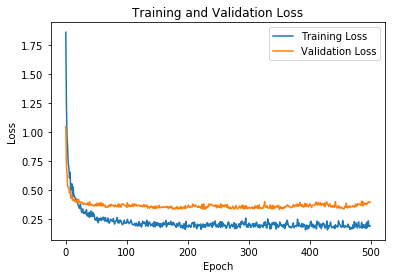

In [18]:
# Plot the training loss and accuracy.
plot_loss(progress2)

307/307 [==============================] - ETA:  - 0s 401us/step


array([[ 21,  26,   0,   0],
       [ 11,  40,   0,   1],
       [  0,   1, 122,   2],
       [  0,   0,   4,  79]], dtype=int64)

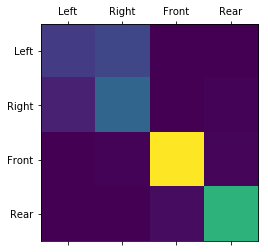

In [19]:
plot_confusion(model2)

In [20]:
# Evaluate the model on the test set. We use the first model here, because it performed better.
loss, accuracy = model.evaluate(x_test, y_test)
'Test Accuracy: {}'.format(accuracy)

310/310 [==============================] - ETA:  - 0s 32us/step


'Test Accuracy: 0.8290322588336083'